In [1]:
import os 
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-1.8.0-openjdk-amd64'

In [1]:
%matplotlib inline

import findspark
findspark.init('D:/spark-2.2.0-bin-hadoop2.7')

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
sess = SparkSession.builder \
                    .appName("foo") \
                    .master("local[*]") \
                    .config("spark.driver.memory", "16g") \
                    .config("spark.sql.shuffle.partitions", 200) \
                    .getOrCreate()

In [4]:
df = sess.read.parquet("./luftdaten.info.20180103.parquet/")

In [5]:
df.count()

646298786

In [6]:
df.schema

StructType(List(StructField(sensor_id,IntegerType,true),StructField(sensor_type,StringType,true),StructField(location,IntegerType,true),StructField(lat,DoubleType,true),StructField(lon,DoubleType,true),StructField(timestamp,TimestampType,true),StructField(P1,StringType,true),StructField(durP1,IntegerType,true),StructField(ratioP1,DoubleType,true),StructField(P2,StringType,true),StructField(durP2,IntegerType,true),StructField(ratioP2,DoubleType,true),StructField(temperature,DoubleType,true),StructField(humidity,DoubleType,true),StructField(pressure,DoubleType,true),StructField(altitude,DoubleType,true),StructField(pressure_sealevel,DoubleType,true)))

## Extract Meta Data

Get all sensors by sensor_id and the geolocation. Delete afterwards that information from the dataframe (except sensor_id).

In [11]:
sensorsOverall = df.select('sensor_id', 'sensor_type', 'location', 'lon', 'lat') \
    .distinct() \
    .persist()
sensorsOverall.count()

7607

Are sendor_ids unique?

In [12]:
sensorsOverall.groupBy(['sensor_id']) \
    .count() \
    .sort(col("count").desc()) \
    .show()

+---------+-----+
|sensor_id|count|
+---------+-----+
|     3160|    5|
|     3159|    5|
|      160|    4|
|      292|    4|
|     4703|    4|
|      321|    4|
|      291|    4|
|     4702|    4|
|     6705|    3|
|      322|    3|
|     5440|    3|
|      230|    3|
|     2363|    3|
|     3175|    3|
|       48|    3|
|      133|    3|
|     6706|    3|
|     1512|    3|
|      570|    3|
|      148|    3|
+---------+-----+
only showing top 20 rows



In [13]:
nonUniqueSensors = sensorsOverall.groupBy(['sensor_id']) \
    .count() \
    .sort(col("count").desc()) \
    .filter(col('count') > 1)
nonUniqueSensors.count()

421

In [35]:
sensorsOverall.filter(col('sensor_id') == 3160).show()

+---------+-----------+--------+-----+------+
|sensor_id|sensor_type|location|  lon|   lat|
+---------+-----------+--------+-----+------+
|     3160|      DHT22|    1591| null|  null|
|     3160|      DHT22|    1591|7.146|51.486|
|     3160|      DHT22|    1591|6.998|51.568|
|     3160|      DHT22|    1591|7.109|51.578|
|     3160|      DHT22|    1591|7.005|51.478|
+---------+-----------+--------+-----+------+



This sensor has different geocoordinates, but the same location id. The uniqueness seems to be identified by the location. 

In [36]:
sensorExample = df.filter(col('sensor_id') == 3160) \
    .sort(col('timestamp').asc()) \
    .persist()

In [37]:
from pyspark.sql.window import Window
window = Window.partitionBy(sensorExample['lon']).orderBy(col('timestamp'))
sensorExample.select('*', rank().over(window).alias('rank')) \
    .filter(col('rank') <= 5) \
    .select(['sensor_id', 'sensor_type', 'lon', 'lat', 'timestamp', 'rank']) \
    .show() 

+---------+-----------+-----+------+-------------------+----+
|sensor_id|sensor_type|  lon|   lat|          timestamp|rank|
+---------+-----------+-----+------+-------------------+----+
|     3160|      DHT22|7.005|51.478|2017-06-01 22:53:07|   1|
|     3160|      DHT22|7.005|51.478|2017-06-01 22:55:35|   2|
|     3160|      DHT22|7.146|51.486|2017-11-04 00:02:13|   1|
|     3160|      DHT22|7.146|51.486|2017-11-04 00:04:39|   2|
|     3160|      DHT22|7.146|51.486|2017-11-04 00:07:06|   3|
|     3160|      DHT22|7.146|51.486|2017-11-04 00:09:33|   4|
|     3160|      DHT22|7.146|51.486|2017-11-04 00:12:00|   5|
|     3160|      DHT22|6.998|51.568|2017-11-03 00:34:25|   1|
|     3160|      DHT22|6.998|51.568|2017-11-03 00:36:53|   2|
|     3160|      DHT22|6.998|51.568|2017-11-03 00:39:21|   3|
|     3160|      DHT22|6.998|51.568|2017-11-03 00:43:38|   4|
|     3160|      DHT22|6.998|51.568|2017-11-03 00:46:04|   5|
|     3160|      DHT22| null|  null|2017-10-09 21:20:25|   1|
|     31

In [38]:
sensorExample.groupBy('lon').count().show()

+-----+-----+
|  lon|count|
+-----+-----+
|7.005|    2|
|7.146|29574|
|6.998|  574|
| null|    1|
|7.109|10886|
+-----+-----+



In [39]:
sensorExample.groupBy('lon') \
    .agg(min('timestamp').alias('first'), max('timestamp').alias('last'), count(lit(1)).alias('n')) \
    .sort(col('first').asc()) \
    .show()
sensorExample.unpersist()

+-----+-------------------+-------------------+-----+
|  lon|              first|               last|    n|
+-----+-------------------+-------------------+-----+
|7.005|2017-06-01 22:53:07|2017-06-01 22:55:35|    2|
|7.109|2017-09-07 10:48:24|2017-10-03 10:36:42|10886|
| null|2017-10-09 21:20:25|2017-10-09 21:20:25|    1|
|6.998|2017-11-03 00:34:25|2017-11-03 23:59:46|  574|
|7.146|2017-11-04 00:02:13|2018-01-01 23:57:49|29574|
+-----+-------------------+-------------------+-----+



DataFrame[sensor_id: int, sensor_type: string, location: int, lat: double, lon: double, timestamp: timestamp, P1: string, durP1: int, ratioP1: double, P2: string, durP2: int, ratioP2: double, temperature: double, humidity: double, pressure: double, altitude: double, pressure_sealevel: double]

It seems to be that: this measurement intervals are distinct and we may use the latest lon and lat of a sensor. Now, let us check this property for each sensor with non-unique lon and lat data.

In [ ]:
nonUniqueSensors = sensorsOverall.groupBy(['sensor_id']) \
    .count() \
    .sort(col('count').desc()) \
    .filter(col('count') > 1).toPandas()
nonUniqueSensors = list(nonUniqueSensors['sensor_id'])

In [ ]:
def isInList(sensorList):
    return udf(lambda sensor_id: sensor_id in sensorList, BooleanType())

dfCheck = df.where(isInList(nonUniqueSensors)('sensor_id'))

In [ ]:
# too slow
# dfCheck = dfCheck.groupBy(['sensor_id', 'lon']) \
#    .agg(min('timestamp').alias('first'), max('timestamp').alias('last'), count(lit(1)).alias('n')) \
#    .sort(col('sensor_id').asc(), col('first').asc()) \
#    .show()

# Subset to Stuttgart Data

In [7]:
dfStgt = df \
    .filter(col('lon') > 9.0) \
    .filter(col('lon') < 9.4) \
    .filter(col('lat') > 48.6) \
    .filter(col('lat') < 49.0) \
    .persist()

In [8]:
dfStgt.count()

131215013

## Extract Meta Data

In [9]:
sensors = dfStgt.select('sensor_id', 'sensor_type', 'location', 'lon', 'lat') \
    .distinct() \
    .sort(col('sensor_id').desc()) \
    .persist()
sensors.show()

+---------+-----------+--------+-----+------+
|sensor_id|sensor_type|location|  lon|   lat|
+---------+-----------+--------+-----+------+
|     8238|     BMP180|    4159|9.188|48.901|
|     8227|     BMP180|    4154|9.012|48.809|
|     8226|      DHT22|    4154|9.012|48.809|
|     8225|     SDS011|    4154|9.012|48.809|
|     8184|      DHT22|    4133|9.087|48.752|
|     8183|     SDS011|    4133|9.087|48.752|
|     8182|      DHT22|    4132|9.152|48.768|
|     8181|     SDS011|    4132|9.152|48.768|
|     8178|      DHT22|    4130|9.133| 48.74|
|     8177|     SDS011|    4130|9.133| 48.74|
|     8175|     SDS011|    4129|  9.1|48.718|
|     8168|      DHT22|    4125|9.186|48.885|
|     8167|     SDS011|    4125|9.186|48.885|
|     8150|      DHT22|    4116|9.273|48.784|
|     8149|     SDS011|    4116|9.273|48.784|
|     8105|      DHT22|    4095|9.105|48.943|
|     8104|     SDS011|    4095|9.105|48.943|
|     7940|     BME280|    4015|9.227|48.887|
|     7939|     SDS011|    4015|9.

In [10]:
# uniqueness of sensors
sensors.groupBy(['sensor_id']) \
    .count() \
    .sort(col("count").desc()) \
    .filter(col('count') > 1) \
    .count()

65

In [11]:
sensors.select('sensor_id', 'sensor_type', 'location') \
    .distinct() \
    .groupBy('location') \
    .count() \
    .filter(col('count') > 3) \
    .sort(col('count').desc()) \
    .show()

+--------+-----+
|location|count|
+--------+-----+
|      19|    9|
|      39|    8|
|     168|    6|
|      64|    6|
|     122|    5|
|     169|    4|
|      40|    4|
|     301|    4|
|     119|    4|
|      42|    4|
|     118|    4|
+--------+-----+



In [ ]:
sensors.filter(col('location') == 19).show()

In [ ]:
dfStgt.filter(col('location') == 19) \
    .groupBy(['sensor_id', 'sensor_type']) \
    .agg(min('timestamp').alias('first'), max('timestamp').alias('last'), count(lit(1)).alias('n')) \
    .sort(col('first').asc()) \
    .show()

In [ ]:
dfSensorSummary = dfStgt.groupBy(['location', 'sensor_id', 'sensor_type']) \
    .agg(min('timestamp').alias('first'), max('timestamp').alias('last'), count(lit(1)).alias('n')) \
    .sort(col('location').asc(), col('first').asc()) 
dfSensorSummary.show()

In [ ]:
dfStgt.select('sensor_type').distinct().show()

We have:

- several sensors ath the same location
- several sensors at the same location are from different type
    - [DHT22](http://de.aliexpress.com/wholesale?site=deu&SortType=price_asc&shipCountry=de&SearchText=dht22&CatId=523): temperature and humiditiy sensor
    - [SDS011](http://de.aliexpress.com/wholesale?site=deu&SortType=price_asc&shipCountry=de&SearchText=sds011&CatId=523): dust sensor
    - [PPD42NS](https://www.seeedstudio.com/Grove-Dust-Sensor%EF%BC%88PPD42NS%EF%BC%89-p-1050.html): alternative dust sensor
    - [BMP180](https://www.bosch-sensortec.com/bst/products/all_products/bmp180): digital barometric pressure sensor
    - [BME280](https://www.bosch-sensortec.com/bst/products/all_products/bme280): barometric pressure and humidity sensor

This setting is described on [http://luftdaten.info/feinstaubsensor-bauen/](http://luftdaten.info/feinstaubsensor-bauen/), except the Bosch sensors. Let us count the sensors:

In [ ]:
dfStgt.select(['sensor_type', 'location']) \
    .distinct() \
    .groupBy('sensor_type') \
    .count() \
    .sort(col('count').desc()) \
    .show()

In [ ]:
dfStgt.select(['sensor_type', 'location']) \
    .distinct() \
    .groupBy('location') \
    .count() \
    .sort(col('count').desc()) \
    .show()

In [12]:
sensorsPD = sensors.toPandas()
sensorsPD.to_csv("stgt_sensors.csv")
sensors.show()

+---------+-----------+--------+-----+------+
|sensor_id|sensor_type|location|  lon|   lat|
+---------+-----------+--------+-----+------+
|     8238|     BMP180|    4159|9.188|48.901|
|     8227|     BMP180|    4154|9.012|48.809|
|     8226|      DHT22|    4154|9.012|48.809|
|     8225|     SDS011|    4154|9.012|48.809|
|     8184|      DHT22|    4133|9.087|48.752|
|     8183|     SDS011|    4133|9.087|48.752|
|     8182|      DHT22|    4132|9.152|48.768|
|     8181|     SDS011|    4132|9.152|48.768|
|     8178|      DHT22|    4130|9.133| 48.74|
|     8177|     SDS011|    4130|9.133| 48.74|
|     8175|     SDS011|    4129|  9.1|48.718|
|     8168|      DHT22|    4125|9.186|48.885|
|     8167|     SDS011|    4125|9.186|48.885|
|     8150|      DHT22|    4116|9.273|48.784|
|     8149|     SDS011|    4116|9.273|48.784|
|     8105|      DHT22|    4095|9.105|48.943|
|     8104|     SDS011|    4095|9.105|48.943|
|     7940|     BME280|    4015|9.227|48.887|
|     7939|     SDS011|    4015|9.

In [ ]:
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

colorscale = [[0, 'rgb(54, 50, 153)'], [0.35, 'rgb(17, 123, 215)'],
                [0.5, 'rgb(37, 180, 167)'], [0.6, 'rgb(134, 191, 118)'],
                [0.7, 'rgb(249, 210, 41)'], [1.0, 'rgb(244, 236, 21)']]
mapbox_access_token = 'pk.eyJ1IjoiamFja3AiLCJhIjoidGpzN0lXVSJ9.7YK6eRwUNFwd3ODZff6JvA'

init_notebook_mode(connected=True)

In [ ]:
data = []

data.append(
    Scattermapbox(
        lon=sensorsPD['lon'].values,
        lat=sensorsPD['lat'].values,
        mode='markers'
    )
)
        
layout = Layout(
    margin=dict(t=0,b=0,r=0,l=0),
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=48.78,
            lon=9.2
        ),
        pitch=0,
        zoom=12,
        style='dark'
    ),
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='foo.html')

# Aggregate Data to Hourly Data

In [13]:
dfTime = dfStgt.select('sensor_id', year('timestamp').alias('year'), 
               month('timestamp').alias('month'), 
               dayofmonth('timestamp').alias('day'), 
               hour('timestamp').alias('hour'), 'P1', 'durP1', 'P2', 'durP2', 'humidity', 'temperature')

In [10]:
dfTime.show()

+---------+----+-----+---+----+----+-----+----+-----+--------+-----------+
|sensor_id|year|month|day|hour|  P1|durP1|  P2|durP2|humidity|temperature|
+---------+----+-----+---+----+----+-----+----+-----+--------+-----------+
|     4741|2017|    9| 21|   0|null| null|null| null|    55.1|       12.2|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.4|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.7|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.6|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.4|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.5|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.4|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.3|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.2|       12.3|
|     4741|2017|    9| 21|   0|null| null|null| null|    55.0|       12.2|
|     4741|2017|    9| 21

In [14]:
dfAgg = dfTime.groupBy(['sensor_id', 'year', 'month', 'day', 'hour']) \
            .agg(mean('P1').alias('P1'), 
                 mean('P2').alias('P2'), 
                 mean('humidity').alias('humidity'), 
                 mean('temperature').alias('temperature'))

In [20]:
dfAgg.show()

+---------+----+-----+---+----+----+----+------------------+------------------+
|sensor_id|year|month|day|hour|  P1|  P2|          humidity|       temperature|
+---------+----+-----+---+----+----+----+------------------+------------------+
|     4741|2017|    8| 26|   7|null|null|40.262735257214544|31.630614805520697|
|     4741|2017|    8| 27|  12|null|null|46.377370417193404|32.416940581542356|
|     4741|2017|    9|  6|   0|null|null| 62.09299363057324|22.007261146496816|
|     4741|2017|    9|  9|  14|null|null| 48.39281129653403|20.274711168164306|
|     4741|2017|    9| 12|   8|null|null|54.964082687338504|17.822868217054264|
|     4741|2017|    9| 10|   1|null|null| 60.10364109232769|16.321456436931076|
|     4741|2017|    9| 19|   0|null|null| 60.13205479452054| 13.12054794520548|
|     4741|2017|   12| 31|  13|null|null| 48.47912087912086|15.588461538461535|
|     4741|2017|   10|  1|  13|null|null|35.838950276243104|24.434530386740324|
|     4741|2017|   10|  9|   8|null|null

In [16]:
from pyspark.sql.functions import unix_timestamp
dfAggTime = dfAgg.select('sensor_id', 'P1', 'P2', 'humidity', 'temperature', concat(col('year'), lit('-'), col('month'), lit("-"), col('day'), lit(" "), col("hour"), lit(':00:00')).alias('timestamp_str'))
dfAggTime = dfAggTime.select('*', from_unixtime(unix_timestamp('timestamp_str', "yyyy-MM-dd H:mm:ss")).alias('timestamp')) \
    .drop('timestamp_str') \
    .sort(col('sensor_id'), col('timestamp')) \
    .persist()
dfStgt.unpersist()
dfAggTime.show()

+---------+------------------+------------------+--------+-----------+-------------------+
|sensor_id|                P1|                P2|humidity|temperature|          timestamp|
+---------+------------------+------------------+--------+-----------+-------------------+
|       34| 568.8695652173913|16.543478260869566|    null|       null|2016-03-29 12:00:00|
|       34| 745.9354385964914| 18.60017543859649|    null|       null|2016-03-29 13:00:00|
|       34| 746.6938655462187| 32.06184873949579|    null|       null|2016-03-29 14:00:00|
|       34|  780.933813559322|24.392457627118635|    null|       null|2016-03-29 15:00:00|
|       34| 972.7716949152542|18.227288135593223|    null|       null|2016-03-29 16:00:00|
|       34| 1029.576068376068|22.139658119658108|    null|       null|2016-03-29 17:00:00|
|       34| 1088.398613861386| 45.69811881188118|    null|       null|2016-03-29 18:00:00|
|       34|1343.3637606837603| 55.21606837606838|    null|       null|2016-03-29 19:00:00|

In [19]:
dfAggTime.count()

3939308

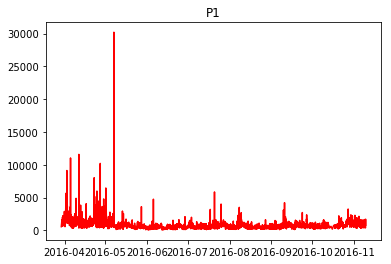

In [15]:
import matplotlib.pyplot as plt

pdExample = dfAggTime.filter(col('sensor_id') == 34).toPandas()
plt.plot_date(pdExample['timestamp'], pdExample['P1'], fmt="r-")
plt.title('P1')

Create a dataframe with unique sensor_id.

In [17]:
sensorsUnique = sensors.groupBy('sensor_id') \
    .agg(first('location').alias('location'), 
         first('sensor_type').alias('sensor_type'), 
         collect_list('lon').alias('lon'), 
         collect_list('lat').alias('lat'))
sensorsUnique.show()

+---------+--------+-----------+--------------+----------------+
|sensor_id|location|sensor_type|           lon|             lat|
+---------+--------+-----------+--------------+----------------+
|     4935|    2483|     SDS011|       [9.155]|         [48.83]|
|     1645|     820|     SDS011|       [9.154]|        [48.744]|
|      148|      39|      DHT22|        [9.18]|        [48.809]|
|     8105|    4095|      DHT22|       [9.105]|        [48.943]|
|     1483|     734|     SDS011|       [9.223]|        [48.781]|
|     1127|     550|      DHT22|       [9.101]|        [48.606]|
|      737|     353|     SDS011|       [9.236]|        [48.801]|
|      243|     106|     SDS011|    [9.3, 9.3]|[48.727, 48.728]|
|     7850|    3970|      DHT22|       [9.343]|        [48.796]|
|     2996|    1508|     SDS011|       [9.111]|        [48.744]|
|     2821|    1418|      DHT22|       [9.168]|        [48.762]|
|     1352|     670|     SDS011|       [9.328]|         [48.83]|
|     1143|     560|     

In [18]:
sensorsUniquePD = sensorsUnique.toPandas()
sensorsUniquePD.to_csv('unique_sensors.csv')

In [20]:
dfAggTime = dfAggTime.join(sensorsUnique, 'sensor_id') \
    .filter(col('sensor_type') != "PPD42NS") \
    .persist()
dfAggTime.show()

+---------+----+----+------------------+------------------+-------------------+--------+-----------+------+--------+
|sensor_id|  P1|  P2|          humidity|       temperature|          timestamp|location|sensor_type|   lon|     lat|
+---------+----+----+------------------+------------------+-------------------+--------+-----------+------+--------+
|      148|null|null| 66.13658536585363| 20.55121951219512|2016-08-14 21:00:00|      39|      DHT22|[9.18]|[48.809]|
|      148|null|null| 66.36021505376344|20.453763440860214|2016-08-14 22:00:00|      39|      DHT22|[9.18]|[48.809]|
|      148|null|null| 71.74148936170212|19.407446808510638|2016-08-14 23:00:00|      39|      DHT22|[9.18]|[48.809]|
|      148|null|null| 76.39890109890109|18.428571428571438|2016-08-15 00:00:00|      39|      DHT22|[9.18]|[48.809]|
|      148|null|null| 79.97176470588235| 17.70705882352942|2016-08-15 01:00:00|      39|      DHT22|[9.18]|[48.809]|
|      148|null|null|  81.4012658227848| 17.38860759493671|2016-

In [21]:
dfAggTimeReindex = dfAggTime.groupBy('location') \
    .agg(collect_list('sensor_id').alias('sensor_id'),
        collect_list('sensor_type').alias('sensor_type'),
        collect_list('timestamp').alias('timestamp'),
        collect_list('P1').alias('P1'),
        collect_list('P2').alias('P2'),
        collect_list('humidity').alias('humidity'),
        collect_list('temperature').alias('temperature'),
        count(lit(1)).alias('n'),
        min('timestamp').alias('start'),
        max('timestamp').alias('end'))

In [22]:
dfAggTimeReindex.count()

457

In [28]:
dfAggTimeReindex.write.parquet('stgt_hourly_mean_by_location.parquet', mode="overwrite")

In [29]:
dfAggTimeReindex.show()

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+-------------------+
|location|           sensor_id|         sensor_type|           timestamp|                  P1|                  P2|            humidity|         temperature|    n|              start|                end|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+-------------------+
|     471|[966, 966, 966, 9...|[SDS011, SDS011, ...|[2017-03-08 04:00...|[11.3394117647058...|[9.91294117647058...|[55.9117647058823...|[11.6294117647058...|12700|2017-03-08 04:00:00|2018-01-01 23:00:00|
|    1342|[2664, 2664, 2664...|[SDS011, SDS011, ...|[2017-05-14 08:00...|[2.88666666666666...|[2.40952380952380...|                  []|                  []| 4356|2017-05-14 08:00:00|2

In [ ]:
dfAggTimeReindex = dfAggTime.groupBy('sensor_id') \
    .agg(collect_list('timestamp').alias('timestamp'), 
        collect_list('P1').alias('P1'),
        collect_list('P2').alias('P2'),
        collect_list('humidity').alias('humidity'),
        collect_list('temperature').alias('temperature'),
        count(lit(1)).alias('n'),
        min('timestamp').alias('start'),
        max('timestamp').alias('end'))

In [ ]:
dfAggTimeReindexWithSensor = dfAggTimeReindex.join(sensorsUnique, 'sensor_id')
dfAggTimeReindexWithSensor.show()

Use just the recommended sensors. TODO: Add Bosch sensors.

In [ ]:
def isInList(sensorTypeList):
    return udf(lambda sensor_type: sensor_type in sensorTypeList, BooleanType())

sensorTypeList = ['DHT22', 'SDS011']
dfAggTimeReindexWithSensor.where(isInList(sensorTypeList)('sensor_type')).count()

In [ ]:
dfAggTime.write.parquet('stgt_hourly_mean.parquet', mode="overwrite")

In [121]:
dfAggTimeReindexWithSensor.write.parquet('stgt_hourly_mean_with_sensors.parquet', mode="overwrite")

In [62]:
dfAggTime.repartition(1).write.csv('stgt_hourly_mean_csv', header=True, mode="overwrite")

In [ ]:
sess.stop()